In [1]:
import pandas as pd
import psycopg2
from collections import defaultdict
from tqdm import tqdm
from datetime import datetime, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, MaxNLocator
from dotenv import load_dotenv
import os
from tldextract import extract
import matplotlib.font_manager as fm
import pandas as pd
import sqlite3
tqdm.pandas()
load_dotenv()
db_path = os.getenv('db_path')

In [ ]:
# Connection setup
conn = sqlite3.connect(db_path)

# Disable autocommit for transaction control
conn.autocommit = False  # Important for named cursors

# To track daily active users
daily_activity = defaultdict(lambda: defaultdict(set))

# To store the first activity date for each user
first_activity = {}

# Define batch size for server-side cursor
batch_size = 10**5  # Adjust based on your system's capacity

try:
    # Table names
    table_names = [
        'blocks',
        'follows',
        'likes',
        'posts',
        'profiles',
        'reposts',
        'feed_generator'
    ]

    # Retrieve data and process it
    for table in table_names:
        batch_no = 0
        print(f"Processing table: {table}")
        # Start a transaction for the server-side cursor
        conn.commit()  # Ensure any previous transactions are committed
        with conn.cursor(name='fetch_large_result') as cur:  # Server-side cursor
            cur.itersize = batch_size
            query = f"SELECT did, createdat FROM {table} WHERE createdat IS NOT NULL"
            cur.execute(query)
            
            while True:
                batch_no += 1
                print(f"Processing batch for table: {table}, Batch #: {batch_no}", end='\r')
                records = cur.fetchmany(batch_size)
                if not records:
                    break
                for did, date in records:
                    if date:
                        date = date.date()  # Ensure it's a date object
                        daily_activity[table][date].add(did)
                        if did not in first_activity:
                            first_activity[did] = date
        conn.commit()  # Commit after processing each table to release the cursor

finally:
    conn.close()  # Ensure connection is closed after the operation

# To store final statistics
stats = defaultdict(lambda: defaultdict(dict))

# Generate stats for daily active and new users
for table, dates in daily_activity.items():
    for datex, users in dates.items():
        stats[table][datex]['no_active'] = len(users)
        stats[table][datex]['no_new'] = sum(1 for user in users if first_activity[user] == datex)


stats = defaultdict(lambda: defaultdict(dict))

# Sort and filter daily_activity by date
for table, dates in tqdm(daily_activity.items(), desc="Sorting daily_activity"):
    # Filter out any entries that aren't already datetime.date objects
    filtered_dates = {k: v for k, v in dates.items() if isinstance(k, date)}
    
    # Sort the filtered dictionary by date
    daily_activity[table] = dict(sorted(filtered_dates.items()))

# Process the sorted and filtered data to calculate statistics
for table, dates in daily_activity.items():
    all_users = set()
    for datex, users in tqdm(dates.items(), desc=f"Processing table: {table}"):
        if datex > pd.Timestamp("2023-01-01").date() and datex < pd.Timestamp("2024-06-01").date():
            stats[table][datex]['no_active'] = len(users)
            stats[table][datex]['no_new'] = len(set(users).difference(all_users))
            all_users.update(users)


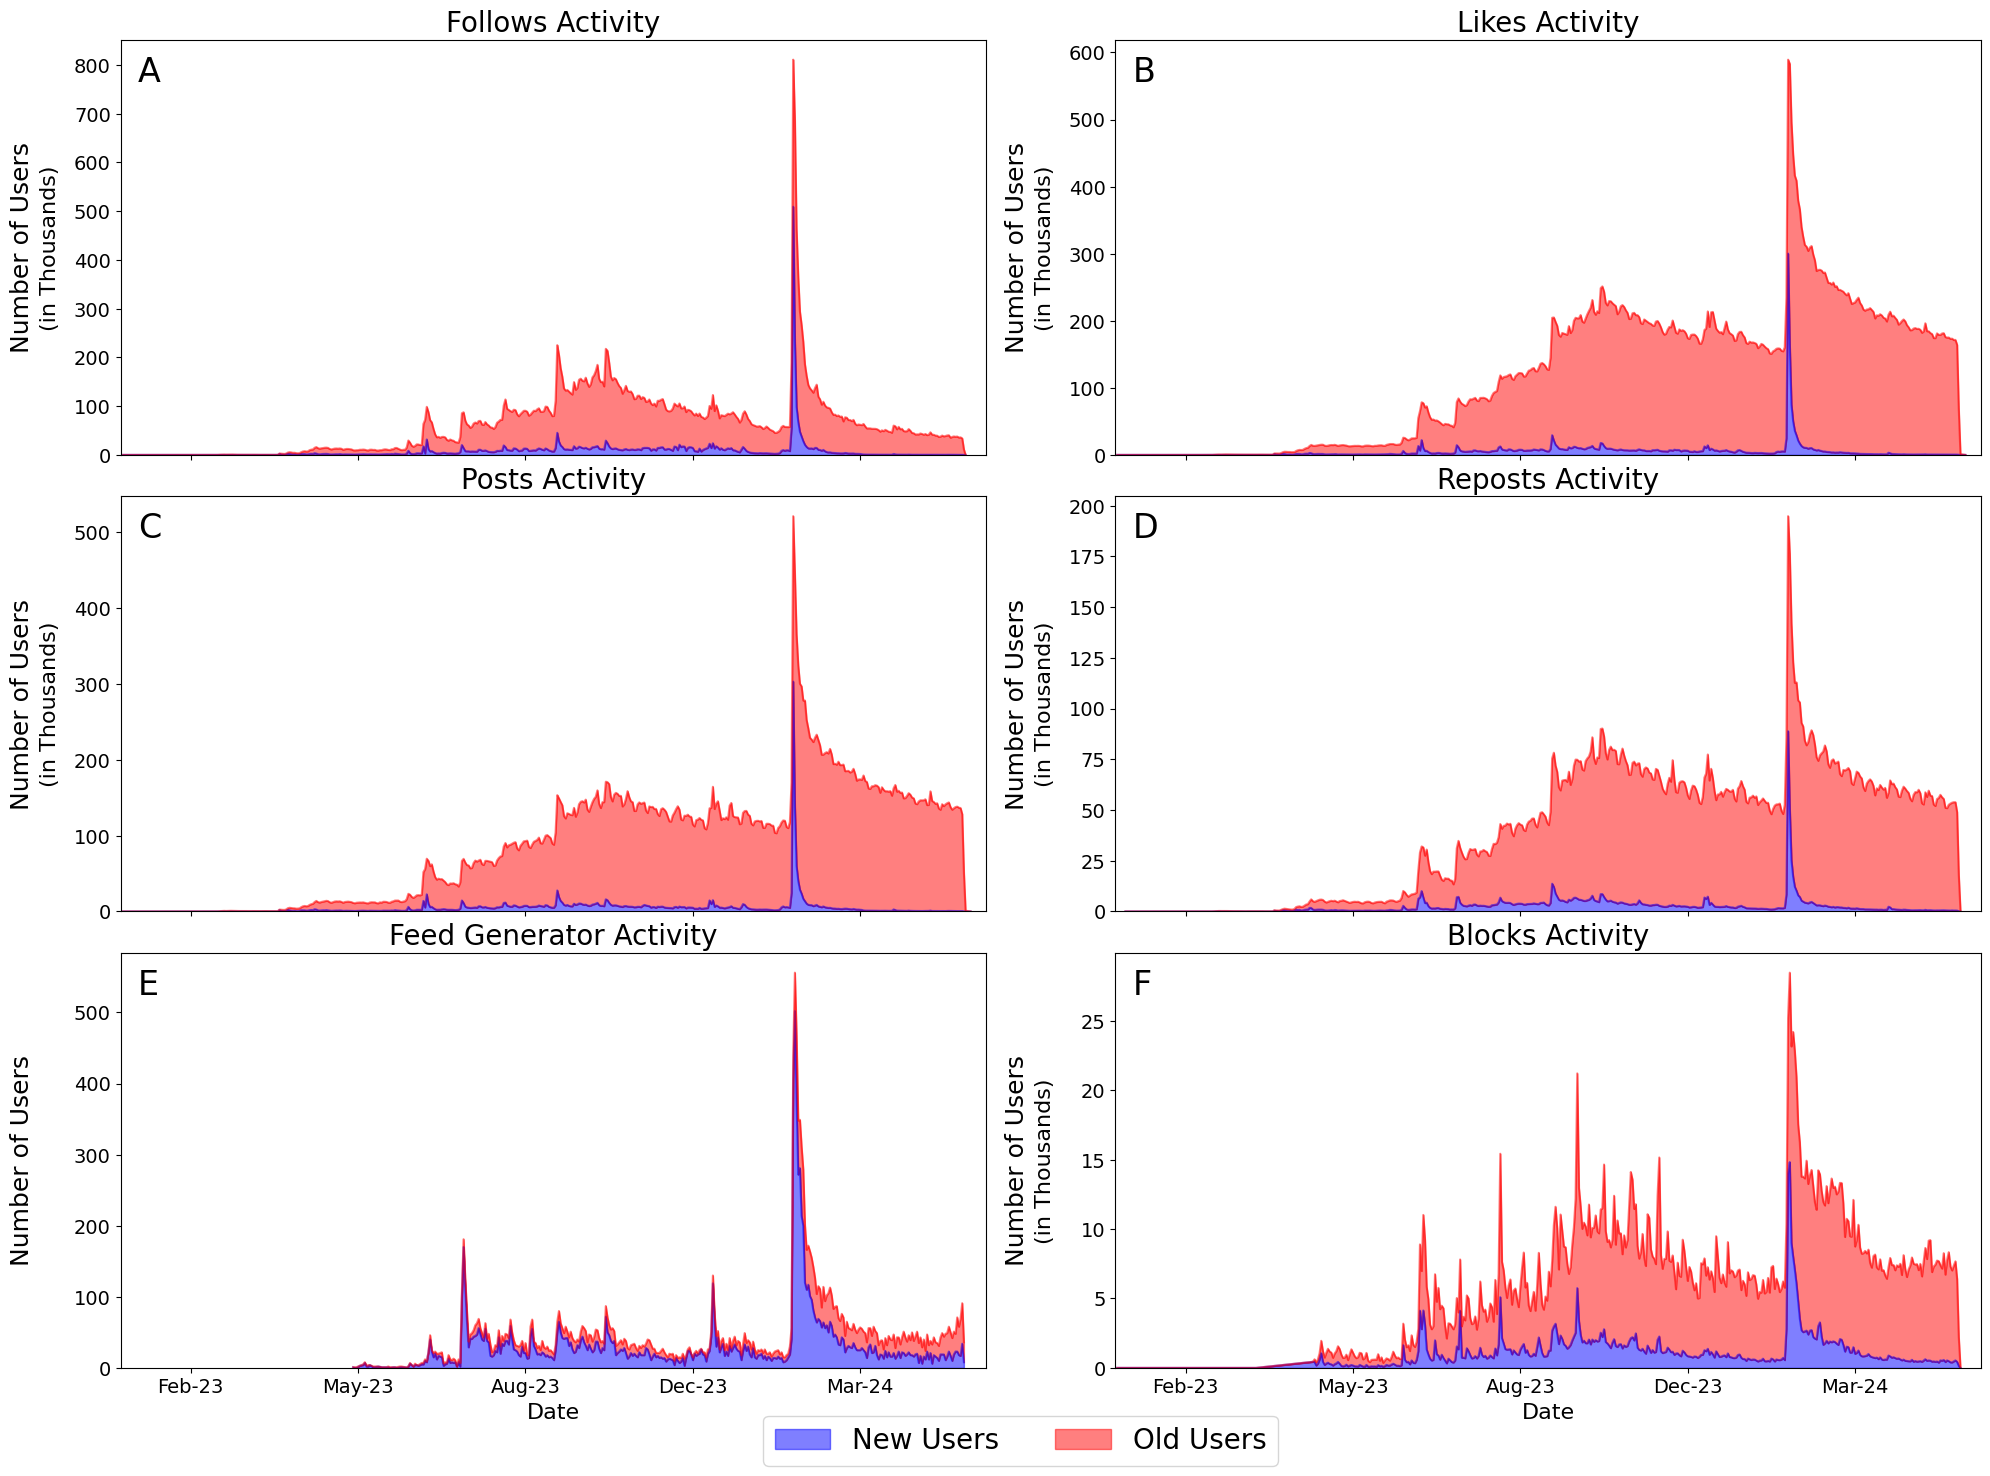

In [7]:
# Set the font to Arial (or Helvetica or FreeSans as fallbacks)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'FreeSans']

# Assume stats and tables_to_plot are already defined

# Set up the figure and axes for the subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(24, 16), sharey=False)
axes = axes.flatten()

# Axis labels
axis_labels = {
    'follows': 'Number of Follows',
    'likes': 'Number of Likes',
    'posts': 'Number of Posts',
    'reposts': 'Number of Reposts',
    'feed_generator': 'Number of Feeds',
    'blocks': 'Number of Blocks'
}

bluesky_events = [
    (date(2023, 7, 3), "Outage", 0.3),
    (date(2023, 9, 19), "Subscription", 0.45),
    (date(2023, 10, 18), " $1 Fee", 0.3),
    (date(2023, 12, 21), "Outage", 0.45),
    (date(2024, 2, 7), "Bluesky Public Opening", 0.85),
]

for ax, table in zip(axes, tables_to_plot):
    # Prepare data
    data = {date: details for date, details in stats[table].items()}
    df = pd.DataFrame.from_dict(data, orient='index')
    df.sort_index(inplace=True)
    df["no_old"] = df["no_active"] - df["no_new"]
    df.drop(columns=["no_active"], inplace=True)
    
    if table != 'feed_generator':
        df /= 1000
        ax.text(-0.1, 0.5, axis_labels[table], fontsize=24, rotation='vertical', va='center', ha='right', transform=ax.transAxes)
        ax.text(-0.07, 0.5, '(in Thousands)', fontsize=20, rotation='vertical', va='center', ha='right', transform=ax.transAxes)
    else:
        ax.text(-0.1, 0.5, axis_labels[table], fontsize=24, rotation='vertical', va='center', ha='right', transform=ax.transAxes)

    # Plot data
    df.plot(kind='area', ax=ax, stacked=True, color=['blue', 'red'], alpha=0.5)
    
    # Set plot details
    ax.set_xlabel('Date', fontsize=24)
    ax.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2024-06-01'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    if ax not in axes[-2:]:
        ax.set_xlabel('')
        ax.set_xticklabels([])

    # Add event annotations
    if table == 'follows':
        # Calculate the maximum y-value
        y_max = df['no_new'].max() + df['no_old'].max()
        ax.set_ylim(0, y_max * 1.15)  # Extend y-axis by 30%
        for i, (event_date, event_desc, annot_height) in enumerate(bluesky_events):
            annotation_height = y_max * annot_height * 1.2  
            if event_date in df.index:
                y_pos = df.loc[event_date, 'no_new'] + df.loc[event_date, 'no_old']
                ax.annotate('', xy=(event_date, y_pos), xytext=(event_date, annotation_height),
                            arrowprops=dict(facecolor='black', shrink=0.05, width=3, headwidth=12, headlength=10))
                ax.text(event_date, annotation_height, event_desc, ha='center', va='bottom', rotation=0, fontsize=22)

# Add labels A-F outside of subplots
labels = "ABCDEF"
for idx, ax in enumerate(axes):
    ax.text(-0.125, 0.88, labels[idx], transform=ax.transAxes, fontsize=36)


# Adjust layout
fig.subplots_adjust(hspace=0.125, bottom=0.05, wspace=0.15, top=0.95) 

# Create a single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, ['New Users', 'Existing Users'], loc='lower center', ncol=2, fontsize=24, bbox_to_anchor=(0.5, -0.02)) 

# Remove individual legends
for ax in axes:
    ax.legend().remove()

plt.savefig("../../Plots/Activity_on_BlueSky_per_Day.png", bbox_inches="tight", dpi=300)
plt.savefig("../../Plots/Activity_on_BlueSky_per_Day.pdf", bbox_inches="tight")
plt.show()

In [103]:
# Top 10 Days of Highest ratio of new users to active users in 2023 for all measures:

for table in tables_to_plot:
    df = pd.DataFrame.from_dict(stats[table], orient='index')
    df["new_to_active_ratio"] = df["no_new"] / (df["no_active"] + df["no_new"])
    # Filter dates for 2023
    df = df.loc[(df.index >= pd.Timestamp("2023-06-01").date()) & (df.index <= pd.Timestamp("2023-12-31").date())]
    # At least 50 new users
    #df = df[df["no_new"] >= 50]
    #top_10_days = df.nlargest(10, "new_to_active_ratio")
    #if table == "follows":
    #    print(top_10_days)
    # Print Days with the highest number of new users
    if table == "follows":
        print(f"Top 10 Days with the Highest Ratio of New Users to Active Users for {table}:")
        print(df.nlargest(20, "no_new"))

Top 10 Days with the Highest Ratio of New Users to Active Users for follows:
            no_active  no_new  new_to_active_ratio
2023-09-19     233244   46810             0.167146
2023-07-03     102128   32713             0.242604
2023-10-18     225412   30209             0.118179
2023-09-20     212452   28297             0.117537
2023-10-19     221359   24851             0.100934
2023-12-21     127574   24670             0.162043
2023-12-19     104355   23657             0.184803
2023-12-01     109575   21447             0.163690
2023-07-24      88528   20969             0.191503
2023-09-21     184628   20135             0.098333
2023-08-18     104822   20100             0.160900
2023-10-13     191691   18762             0.089151
2023-09-29     154986   18425             0.106250
2023-12-23     105894   18342             0.147638
2023-07-01      65797   18160             0.216301
2023-12-03      99482   17891             0.152429
2023-10-20     196263   17729             0.082849
2023-

## Top Domains (Political/Non Political/Fake News)

In [2]:


conn = sqlite3.connect(db_path)
# Define the query
query = "SELECT did, link FROM posts"
df = pd.read_sql_query(query, conn)
df = df[~(df["link"] == "") & ~(df["link"].isnull())]


map_unshortened_df = pd.read_csv("../../Data/UnshortenBatches/unshortened_urls.csv.gz")
link2longlink = map_unshortened_df.set_index("link")["unshortened_url"].to_dict()
df["link"] = df["link"].apply(lambda x: link2longlink.get(x, x))

In [3]:

def get_domain(x):
    var = extract(x)
    domain, suffix = var.domain, var.suffix
    return f"{domain}.{suffix}"
df["domain"] = df["link"].progress_apply(lambda x: get_domain(x))
# Load Political and Fakenews
political = pd.read_csv("../../Data/MBFC_Data/mediabiasfactcheck_fulldataset.csv")
fakenews = pd.read_csv("../../Data/MBFC_Data/mediabiasfactcheck_fakenews.csv")
# Filter df for accounts with less than 10.000 posts
# remove facebook as domain
df_red = df.groupby("did").filter(lambda x: len(x) < 10000)
fake_news = fakenews[(fakenews["Reasoning"].str.contains("fake|propa|conspi", case=False, na=False)) | (fakenews["Questionable Reasoning"].str.contains("fake|propa|conspi", case=False, na=False))]
political["domain"] = political["sourcelink"].progress_apply(lambda x: get_domain(x))
fake_news["domain"] = fake_news["source_link"].progress_apply(lambda x: get_domain(x))
fake_news = fake_news[~fake_news["domain"].str.contains("facebook")]
fake_news = fake_news[~fake_news["domain"].str.contains("rumble")]
political = political[~political["domain"].str.contains("wikipedia")]
political = political[~political["domain"].str.contains("blogspot")]
political = political[~political["domain"].str.contains("wordpress")]

# remove apple.com and google.com
political = political[~political["domain"].str.contains("apple")]
political = political[~political["domain"].str.contains("google")]
domain_counts_overall = df_red["domain"].value_counts().head(20)
domain_counts_political = df_red[df_red["domain"].isin(political["domain"])]["domain"].value_counts().head(20)
domain_counts_fakenews = df_red[df_red["domain"].isin(fake_news["domain"])]["domain"].value_counts().head(20)

# To print with "," thousand separator f"{domain_counts_overall.values[i]:,}"
for i in range(len(domain_counts_overall)):
    print(f"{domain_counts_overall.index[i]} & {domain_counts_overall.values[i]:,} & {domain_counts_political.index[i]} & {domain_counts_political.values[i]:,} & {domain_counts_fakenews.index[i]} & {domain_counts_fakenews.values[i]:,} \\\\")

100%|██████████| 615/615 [00:00<00:00, 50362.11it/s]
/tmp/ipykernel_2345445/3021339144.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_news["domain"] = fake_news["source_link"].progress_apply(lambda x: get_domain(x))


youtube.com & 1,665,744 & theguardian.com & 124,123 & dailymail.co.uk & 2,501 \\
spotify.com & 237,786 & nytimes.com & 82,963 & mondoweiss.net & 2,249 \\
tenor.com & 185,865 & washingtonpost.com & 33,388 & foxnews.com & 870 \\
twitch.tv & 185,268 & tagesschau.de & 29,454 & newsbreak.com & 430 \\
theguardian.com & 124,123 & bbc.com & 27,973 & indiatimes.com & 401 \\
substack.com & 86,116 & cnn.com & 26,838 & thenationalnews.com & 318 \\
instagram.com & 83,077 & spiegel.de & 23,757 & moveon.org & 279 \\
nytimes.com & 82,963 & apnews.com & 23,305 & almayadeen.net & 270 \\
twitter.com & 77,440 & reuters.com & 23,230 & theepochtimes.com & 262 \\
openstreetmap.org & 68,503 & theverge.com & 21,578 & presstv.ir & 244 \\
apple.com & 64,594 & nbcnews.com & 16,967 & news.cn & 232 \\
wikipedia.org & 62,453 & medium.com & 16,867 & hindustantimes.com & 229 \\
blogspot.com & 52,605 & nhk.or.jp & 16,026 & alarabiya.net & 210 \\
x.com & 47,357 & arstechnica.com & 12,319 & rt.com & 208 \\
bandcamp.com &

In [26]:
# What URLs are shared by automated accounts?
print(df.groupby("did").filter(lambda x: len(x) > 10000).domain.value_counts(normalize = False).head(10))

domain
globo.com           176009
osintukraine.com     94582
yahoo.co.jp          69970
9to5mac.com          60381
lemonde.fr           48482
spotify.com          40939
syui.ai              36885
theguardian.com      36575
youtube.com          35656
hs.fi                29845
Name: count, dtype: int64


### Review Questions:

- What percentage of domains in the data-set are in the MBFC Rating
- WHat is the influence of altering the number of URLs to 1.000 instead of 10.000

In [34]:
all = set(df.did.unique())
less_than_10k = set(df.groupby("did").filter(lambda x: len(x) < 10000).did.unique())
less_than_1k = set(df.groupby("did").filter(lambda x: len(x) < 1000).did.unique())

fake_news = fakenews[(fakenews["Reasoning"].str.contains("fake|propa|conspi", case=False, na=False)) | (fakenews["Questionable Reasoning"].str.contains("fake|propa|conspi", case=False, na=False))]
political["domain"] = political["sourcelink"].progress_apply(lambda x: get_domain(x))
fake_news["domain"] = fake_news["source_link"].progress_apply(lambda x: get_domain(x))
fake_news = fake_news[~fake_news["domain"].str.contains("facebook")]
fake_news = fake_news[~fake_news["domain"].str.contains("rumble")]
political = political[~political["domain"].str.contains("wikipedia")]
political = political[~political["domain"].str.contains("blogspot")]
political = political[~political["domain"].str.contains("wordpress")]

# remove apple.com and google.com
political = political[~political["domain"].str.contains("apple")]
political = political[~political["domain"].str.contains("google")]

for did_set in [all, less_than_10k, less_than_1k]:
    df_red = df[df.did.isin(did_set)]
    domain_counts_overall = df_red["domain"].value_counts().head(20)
    domain_counts_political = df_red[df_red["domain"].isin(political["domain"])]["domain"].value_counts().head(20)
    domain_counts_fakenews = df_red[df_red["domain"].isin(fake_news["domain"])]["domain"].value_counts().head(20)

    # To print with "," thousand separator f"{domain_counts_overall.values[i]:,}"
    for i in range(len(domain_counts_overall)):
        print(f"{domain_counts_overall.index[i]} & {domain_counts_overall.values[i]:,} & {domain_counts_political.index[i]} & {domain_counts_political.values[i]:,} & {domain_counts_fakenews.index[i]} & {domain_counts_fakenews.values[i]:,} \\\\")


100%|██████████| 615/615 [00:00<00:00, 48919.89it/s]
/tmp/ipykernel_447567/1120750603.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_news["domain"] = fake_news["source_link"].progress_apply(lambda x: get_domain(x))


youtube.com & 1,701,400 & theguardian.com & 160,698 & dailymail.co.uk & 2,975 \\
spotify.com & 278,725 & nytimes.com & 86,628 & mondoweiss.net & 2,249 \\
tenor.com & 185,907 & lemonde.fr & 60,686 & foxnews.com & 1,236 \\
twitch.tv & 185,269 & apnews.com & 40,752 & indiatimes.com & 615 \\
globo.com & 179,582 & hs.fi & 40,389 & newsbreak.com & 430 \\
theguardian.com & 160,698 & reuters.com & 37,954 & hindustantimes.com & 354 \\
yahoo.co.jp & 97,676 & washingtonpost.com & 35,396 & thenationalnews.com & 320 \\
osintukraine.com & 95,345 & bbc.com & 34,235 & alarabiya.net & 282 \\
instagram.com & 89,949 & tagesschau.de & 29,454 & moveon.org & 279 \\
nytimes.com & 86,628 & cnn.com & 28,830 & almayadeen.net & 274 \\
substack.com & 86,273 & ft.com & 28,696 & theepochtimes.com & 262 \\
twitter.com & 77,486 & ad.nl & 28,248 & presstv.ir & 245 \\
openstreetmap.org & 68,503 & nhk.or.jp & 27,811 & news.cn & 242 \\
bandcamp.com & 65,542 & spiegel.de & 23,806 & rt.com & 234 \\
apple.com & 64,601 & zei

In [39]:
total_count = df.shape[0]
political_count_no_limit = df[df["domain"].isin(political["domain"])]["domain"].shape[0]
fakenews_count_no_limit = df[df["domain"].isin(fake_news["domain"])]["domain"].shape[0]

df_red = df.groupby("did").filter(lambda x: len(x) < 10000)
total_count_10k = df_red.shape[0]
political_count_10k = df_red[df_red["domain"].isin(political["domain"])]["domain"].shape[0]
fakenews_count_10k = df_red[df_red["domain"].isin(fake_news["domain"])]["domain"].shape[0]

df_red = df.groupby("did").filter(lambda x: len(x) < 1000)
total_count_1k = df_red.shape[0]
political_count_1k = df_red[df_red["domain"].isin(political["domain"])]["domain"].shape[0]
fakenews_count_1k = df_red[df_red["domain"].isin(fake_news["domain"])]["domain"].shape[0]

print(f"Total Count: {total_count}")
print(f"Political Count No Limit: {political_count_no_limit} Perc of Total: {political_count_no_limit / total_count}")
print(f"Fakenews Count No Limit: {fakenews_count_no_limit} Perc of Total: {fakenews_count_no_limit / total_count}")

print(f"Total Count 10k: {total_count_10k} Perc of Total: {total_count_10k / total_count}")
print(f"Political Count 10k: {political_count_10k} Perc of Total: {political_count_10k / total_count_10k}")
print(f"Fakenews Count 10k: {fakenews_count_10k} Perc of Total: {fakenews_count_10k / total_count_10k}")


print(f"Total Count 1k: {total_count_1k} Perc of Total: {total_count_1k / total_count}")
print(f"Political Count 1k: {political_count_1k} Perc of Total: {political_count_1k / total_count_1k}")
print(f"Fakenews Count 1k: {fakenews_count_1k} Perc of Total: {fakenews_count_1k / total_count_1k}")

Total Count: 9929672
Political Count No Limit: 2055596 Perc of Total: 0.20701549859854385
Fakenews Count No Limit: 13409 Perc of Total: 0.0013503970725317008
Total Count 10k: 8409741 Perc of Total: 0.8469303920612886
Political Count 10k: 1582455 Perc of Total: 0.18816929082596004
Fakenews Count 10k: 11984 Perc of Total: 0.0014250141591756512
Total Count 1k: 6756586 Perc of Total: 0.6804440267513368
Political Count 1k: 1138525 Perc of Total: 0.16850595848258276
Fakenews Count 1k: 7638 Perc of Total: 0.0011304525687973186


In [55]:
all_domains = set(df.domain.unique())
political_domains = set(political["domain"].unique())
fake_news_domains = set(fake_news["domain"].unique())
rated_domains = political_domains | fake_news_domains
percentage_rated = len(all_domains & rated_domains) / len(all_domains)
print(f"Percentage of Rated Domains: {percentage_rated}")

Percentage of Rated Domains: 0.012860846514608639


In [54]:
# group by domain => set(dids) => include if set(dids) > 1
df_red = df.groupby("domain").filter(lambda x: len(set(x.did.unique())) > 1)
df_red_rated = df_red[df_red["domain"].isin(rated_domains)]
percentage_rated = df_red_rated.shape[0] / df_red.shape[0]
print(f"Percentage of Rated Domains: {percentage_rated}")

Percentage of Rated Domains: 0.2177568016579311


In [2]:
def get_domain(x):
    var = extract(x)
    domain, suffix = var.domain, var.suffix
    return f"{domain}.{suffix}"

df["domain"] = df["link"].progress_apply(lambda x: get_domain(x))
# Load Political and Fakenews
political = pd.read_csv("../../Data/MBFC_Data/mediabiasfactcheck_fulldataset.csv")
fakenews = pd.read_csv("../../Data/MBFC_Data/mediabiasfactcheck_fakenews.csv")
# Filter df for accounts with less than 10.000 posts
# remove facebook as domain
df_red = df.groupby("did").filter(lambda x: len(x) < 10000)
fake_news = fakenews[(fakenews["Reasoning"].str.contains("fake|propa|conspi", case=False, na=False)) | (fakenews["Questionable Reasoning"].str.contains("fake|propa|conspi", case=False, na=False))]
political["domain"] = political["sourcelink"].progress_apply(lambda x: get_domain(x))
fake_news["domain"] = fake_news["source_link"].progress_apply(lambda x: get_domain(x))
fake_news = fake_news[~fake_news["domain"].str.contains("facebook")]
fake_news = fake_news[~fake_news["domain"].str.contains("rumble")]
political = political[~political["domain"].str.contains("wikipedia")]
political = political[~political["domain"].str.contains("blogspot")]
political = political[~political["domain"].str.contains("wordpress")]

# remove apple.com and google.com
political = political[~political["domain"].str.contains("apple")]
political = political[~political["domain"].str.contains("google")]
domain_counts_overall = df_red["domain"].value_counts().head(20)
domain_counts_political = df_red[df_red["domain"].isin(political["domain"])]["domain"].value_counts().head(20)
domain_counts_fakenews = df_red[df_red["domain"].isin(fake_news["domain"])]["domain"].value_counts().head(20)

# To print with "," thousand separator f"{domain_counts_overall.values[i]:,}"
for i in range(len(domain_counts_overall)):
    print(f"{domain_counts_overall.index[i]} & {domain_counts_overall.values[i]:,} & {domain_counts_political.index[i]} & {domain_counts_political.values[i]:,} & {domain_counts_fakenews.index[i]} & {domain_counts_fakenews.values[i]:,} \\\\")


  0%|          | 0/9929672 [00:00<?, ?it/s]

100%|██████████| 615/615 [00:00<00:00, 42367.40it/s]
/tmp/ipykernel_386855/1037263894.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_news["domain"] = fake_news["source_link"].progress_apply(lambda x: get_domain(x))


youtube.com & 1,665,744 & theguardian.com & 124,123 & dailymail.co.uk & 2,501 \\
spotify.com & 237,786 & nytimes.com & 82,963 & mondoweiss.net & 2,249 \\
tenor.com & 185,865 & washingtonpost.com & 33,388 & foxnews.com & 870 \\
twitch.tv & 185,268 & tagesschau.de & 29,454 & newsbreak.com & 430 \\
theguardian.com & 124,123 & bbc.com & 27,973 & indiatimes.com & 401 \\
substack.com & 86,116 & cnn.com & 26,838 & thenationalnews.com & 318 \\
instagram.com & 83,077 & spiegel.de & 23,757 & moveon.org & 279 \\
nytimes.com & 82,963 & apnews.com & 23,305 & almayadeen.net & 270 \\
twitter.com & 77,440 & reuters.com & 23,230 & theepochtimes.com & 262 \\
openstreetmap.org & 68,503 & theverge.com & 21,578 & presstv.ir & 244 \\
apple.com & 64,594 & nbcnews.com & 16,967 & news.cn & 232 \\
wikipedia.org & 62,453 & medium.com & 16,867 & hindustantimes.com & 229 \\
blogspot.com & 52,605 & nhk.or.jp & 16,026 & alarabiya.net & 210 \\
x.com & 47,357 & arstechnica.com & 12,319 & rt.com & 208 \\
bandcamp.com &